In [125]:
import torch
import os
import random
from PIL import Image
from glob import glob
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
from torchinfo import summary
from torchmetrics import Accuracy
from tqdm.auto import tqdm
from typing import Tuple, Dict, List
import requests


In [101]:
# get device gpu
dev = "cuda" if torch.cuda.is_available() else "cpu"

# check the files that there are
dir_path = "./data/pizza_steak_sushi/"
def walk_through_dir(dir_path):
    for dirpath, dirnames, filesnames in os.walk(dir_path):
        print(f"There are {len(dirnames)}  directories and {len(filesnames)} images in {dirpath}")

walk_through_dir(dir_path)

There are 2  directories and 0 images in ./data/pizza_steak_sushi/
There are 3  directories and 0 images in ./data/pizza_steak_sushi/test
There are 0  directories and 25 images in ./data/pizza_steak_sushi/test/pizza
There are 0  directories and 19 images in ./data/pizza_steak_sushi/test/steak
There are 0  directories and 31 images in ./data/pizza_steak_sushi/test/sushi
There are 3  directories and 0 images in ./data/pizza_steak_sushi/train
There are 0  directories and 78 images in ./data/pizza_steak_sushi/train/pizza
There are 0  directories and 75 images in ./data/pizza_steak_sushi/train/steak
There are 0  directories and 72 images in ./data/pizza_steak_sushi/train/sushi


Random image path: sushi
Image class: train
Image height: 512
Image width: 512


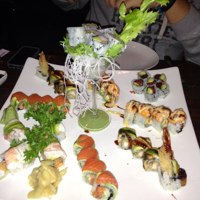

In [102]:
# get all image 
image_path_list = list(glob(dir_path + "*/*/*.jpg"))

# pick a random image path
random_image_path = random.choice(image_path_list)

# parent file and parent image
parent = os.path.dirname(random_image_path)

# Open image
img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {parent.split('/')[4]}")
print(f"Image class: {parent.split('/')[3]}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img.resize(size=(200,200))

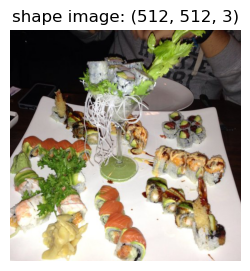

In [103]:
# show image with plt
img_as_array = np.asanyarray(img)
plt.figure(figsize=(3,3))
plt.imshow(img_as_array)
plt.title(f"shape image: {img_as_array.shape}")
plt.axis(False);

In [104]:
# transforming data with torchvision.transform (data augmentation)
train_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),        # Change size image to 64x64
    # transforms.RandomHorizontalFlip(p=0.5), #Flip the images randomly on the horizontal
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor()
    ])

test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

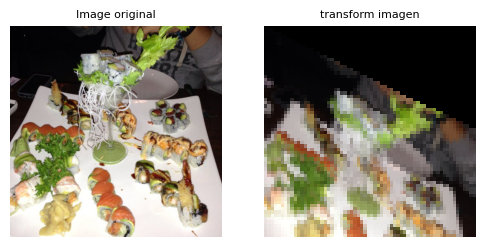

In [105]:
# check image after anb before data transform
plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Image original", size=8)
plt.axis(False);

plt.subplot(1,2,2)
plt.imshow(train_transform(img).permute(1, 2, 0)) # PERMUTE DIMESION
plt.title("transform imagen", size=8)
plt.axis(False);

In [106]:
# build func check before and after image data transform
def display_random_images(dataset:Dataset, classes: list[str]=None, n:int=10,
                          display_shape:bool = True, seed:int=42):

    random.seed(seed)
    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(8,8))

    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        targ_image_adjust = targ_image.permute(1,2,0)

        plt.subplot(1,n,i+1)
        plt.imshow(targ_image_adjust)
        plt.axis(False)
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape:{list(targ_image_adjust.shape)}"
        plt.title(title, fontsize =8)

In [107]:
# setup train and test paths
train_dir = "./data/pizza_steak_sushi/train"
test_dir = "./data/pizza_steak_sushi/test"

In [108]:
# Use ImageFolder to create datasets
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transform,
                                              target_transform=None)
test_data = torchvision.datasets.ImageFolder(root=test_dir, transform=test_transform)
print(f"Train data: \n{train_data}\n Test data: \n{test_data}")

Train data: 
Dataset ImageFolder
    Number of datapoints: 225
    Root location: ./data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
               ToTensor()
           )
 Test data: 
Dataset ImageFolder
    Number of datapoints: 75
    Root location: ./data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )


In [109]:
# get class names as a list
class_names = train_data.classes

# get class names as a dict
class_dic = train_data.class_to_idx

print(f"Class names in list: {class_names}\nClass name in Dict: {class_dic}")

Class names in list: ['pizza', 'steak', 'sushi']
Class name in Dict: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [110]:
len(train_data), len(test_data)

(225, 75)

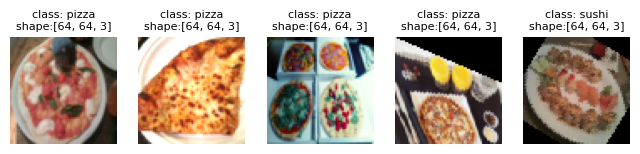

In [111]:
display_random_images(train_data, n=5, classes=class_names, seed=None)

In [112]:
# turn loaded images into DataLoader
BATCH_SIZE = 3 # with Batch add one dimesion shape: [batch, color_channel, height, width]
train_dataloader = DataLoader(dataset= train_data, batch_size=BATCH_SIZE,
                              num_workers=1, shuffle=True) #num_workers= os.cpu_count() # Nucleos de la pc
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE,
                             num_workers=1, shuffle=False)

len(train_dataloader), len(test_dataloader)

(75, 25)

In [113]:
#  Create TinyVGG model class
class TinyVGG(nn.Module):
    def __init__(self, input_shape, output, hidden) :
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)            
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden, out_channels=hidden, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden*16*16, out_features=output)
        )
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        #print(x.shape)
        x = self.block_3(x)
        return x

torch.manual_seed(42)
torch.cuda.manual_seed(42)    
model_0 = TinyVGG(input_shape=3, output=len(train_data.classes), hidden=10).to(dev)
model_0

TinyVGG(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_3): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [114]:
# get a simple image batch
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape, label_batch.shape

(torch.Size([3, 3, 64, 64]), torch.Size([3]))

In [115]:
x = summary(model=model_0, input_size=[3,3,64,64])# [batch, color_channel, heght, width] of image
x

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [3, 3]                    --
├─Sequential: 1-1                        [3, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [3, 10, 64, 64]           280
│    └─ReLU: 2-2                         [3, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [3, 10, 64, 64]           910
│    └─ReLU: 2-4                         [3, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [3, 10, 32, 32]           --
├─Sequential: 1-2                        [3, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [3, 10, 32, 32]           910
│    └─ReLU: 2-7                         [3, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [3, 10, 32, 32]           910
│    └─ReLU: 2-9                         [3, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [3, 10, 16, 16]           --
├─Sequentia

In [116]:
# loss, optimizer and accuracy
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy("multiclass", num_classes=len(train_data.classes)).to(dev)

In [117]:
def train_step(model: nn.Module, dataloader: DataLoader, 
               loss_fn: nn.Module, optimizer: torch.optim.Optimizer):
    
    train_loss, train_acc = 0, 0    
    model.train()   
    for batch, (x, y) in enumerate(dataloader):
     
        x, y = x.to(dev), y.to(dev)
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_acc += acc_fn(y, y_pred.argmax(dim=1)).item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [118]:
def test_step(model: nn.Module, dataloader: DataLoader, loss_fn: nn.Module):

    test_loss, test_acc = 0, 0
    model.eval()     
    with torch.inference_mode():
        for batch, (x, y) in enumerate(dataloader):
            
            x, y = x.to(dev), y.to(dev)
            test_pred = model(x)
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_acc += acc_fn(y, test_pred.argmax(dim=1)).item()    
                
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [119]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, 
          optimizer: torch.optim.Optimizer,loss_fn, epochs: int = 5):
    
    results = {"train_loss": [], "train_acc": [], # 2. Create empty results dictionary
               "test_loss": [], "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc = train_step(model=model, dataloader=train_dataloader,
                                           loss_fn=loss_fn, optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,dataloader=test_dataloader,
                                        loss_fn=loss_fn)
        
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}" )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)      

    return results

In [120]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5

model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

 20%|██        | 1/5 [00:01<00:04,  1.04s/it]

Epoch: 1 | train_loss: 1.1146 | train_acc: 0.3333 | test_loss: 1.1033 | test_acc: 0.3333


 40%|████      | 2/5 [00:02<00:03,  1.04s/it]

Epoch: 2 | train_loss: 1.1014 | train_acc: 0.3156 | test_loss: 1.1006 | test_acc: 0.3333


 60%|██████    | 3/5 [00:03<00:02,  1.03s/it]

Epoch: 3 | train_loss: 1.1001 | train_acc: 0.3111 | test_loss: 1.1012 | test_acc: 0.2533


 80%|████████  | 4/5 [00:04<00:01,  1.03s/it]

Epoch: 4 | train_loss: 1.0987 | train_acc: 0.3378 | test_loss: 1.1011 | test_acc: 0.3333


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]

Epoch: 5 | train_loss: 1.0987 | train_acc: 0.3467 | test_loss: 1.1015 | test_acc: 0.3333


In [121]:
model_0_results

{'train_loss': [1.114563556512197,
  1.101408077875773,
  1.1001482629776,
  1.0987216265996298,
  1.0986522626876831],
 'train_acc': [0.3333333424727122,
  0.31555556376775107,
  0.31111111958821613,
  0.33777778784434,
  0.3466666766007741],
 'test_loss': [1.1032601976394654,
  1.1006191730499268,
  1.1012320470809938,
  1.1011017751693726,
  1.1015258312225342],
 'test_acc': [0.3333333337306976,
  0.3333333337306976,
  0.25333333492279053,
  0.3333333337306976,
  0.3333333337306976]}

In [122]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [123]:
def plot_loss_curves(results: Dict[str, List[float]]):
    
    loss = results['train_loss']
    test_loss = results['test_loss']

    train_accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(12, 3))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

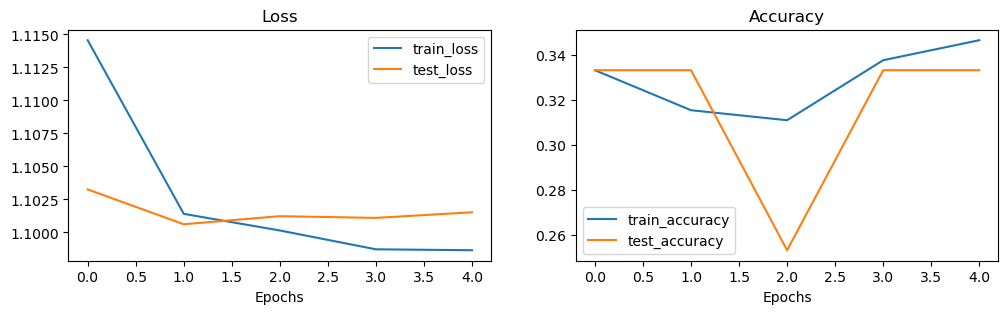

In [124]:
plot_loss_curves(model_0_results)

# Make a prediction on a custom image


In [131]:
# Download custom image
custom_image_path = "./data/pizza_steak_sushi/04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not os.path.isfile(custom_image_path):
    with open(custom_image_path, "wb") as f:        
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

./data/pizza_steak_sushi/04-pizza-dad.jpeg already exists, skipping download.


In [160]:
type(custom_image_path) # change to str if download image with request why is type POSIX

str

In [179]:
# Loading in a custom image with PyTorch
custom_image = torchvision.io.read_image(custom_image_path).type(torch.float32) # NECESARIO CAMBIAR A FLOAT32

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

custom_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])

custom_image_transform = custom_transform(custom_image)
print(f"Custom image shape: {custom_image_transform.shape}\n")
print(f"Custom image dtype: {custom_image_transform.dtype}")

Custom image shape: torch.Size([3, 64, 64])

Custom image dtype: torch.float32


In [162]:
# Try to make a prediction on image in uint8 format (this will error)
model_0.eval()
with torch.inference_mode():
    
    custom_image_pred = model_0(custom_image_transform.unsqueeze(dim=0).to(dev)) # add extra dimension [+ batch]

In [180]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

Prediction logits: tensor([[ 0.0270,  0.0165, -0.0164]], device='cuda:0')
Prediction probabilities: tensor([[0.3393, 0.3358, 0.3249]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


'pizza'

In [1]:
2+2

4